## Yandex boot camp - Milestone 1

Data comes from online store Ice, which sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. The goal of analysis is to identify patterns that determine whether a game succeeds or not.

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import zscore
from scipy.stats import norm
from scipy.stats import skewnorm
from sklearn.linear_model import LinearRegression
import seaborn as sns

import warnings
warnings.simplefilter ('ignore')

# import file
games = pd.read_csv('games.csv')

### 1. Data Preprocessing

In [2]:
games.shape

(16715, 11)

In [3]:
games.head(3)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E


In [4]:
games.set_axis(['name','platform','year','genre','NA_sales','EU_sales','JP_sales','other_sales','critic_score','user_score','rating'],axis='columns',inplace=True)

column names replaced for lowercase

In [5]:
games['total_sales'] = games.NA_sales + games.EU_sales + games.JP_sales + games.other_sales

column total sales of all regions added

In [6]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          16713 non-null  object 
 1   platform      16715 non-null  object 
 2   year          16446 non-null  float64
 3   genre         16713 non-null  object 
 4   NA_sales      16715 non-null  float64
 5   EU_sales      16715 non-null  float64
 6   JP_sales      16715 non-null  float64
 7   other_sales   16715 non-null  float64
 8   critic_score  8137 non-null   float64
 9   user_score    10014 non-null  object 
 10  rating        9949 non-null   object 
 11  total_sales   16715 non-null  float64
dtypes: float64(7), object(5)
memory usage: 1.5+ MB


In [7]:
games[games.user_score=='tbd'].count()[0]

2424

user score column is type object, not float - to be fixed later

In [8]:
games.duplicated().sum()

0

no duplicates in the data set

In [9]:
games.isnull().sum()

name               2
platform           0
year             269
genre              2
NA_sales           0
EU_sales           0
JP_sales           0
other_sales        0
critic_score    8578
user_score      6701
rating          6766
total_sales        0
dtype: int64

Several columns with NaN values: Name/genre are presumably erroneous entries. Year of game release is a publicly available information that should not be missing, so there could be an issue with the data query. Critic score, user score and rating might simply not exist for all games (some of them being >30 years old), but as they represent missing values in about a third of the data set, we'll have to find means to handle them.

#### 1.1 Missing values in name + year columns

In [10]:
games[games.name.isnull()]

,name,platform,year,genre,NA_sales,EU_sales,JP_sales,other_sales,critic_score,user_score,rating,total_sales
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN,2.39
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN,0.03


In [11]:
games.dropna(subset=['name'],inplace=True)
games.reset_index(drop=True,inplace=True)

Drop two rows with missing names of games and genres

In [12]:
# split potential year from name of game (e.g. FIFA 2014)

def get_int(x):
    try:
        int(x.split()[-1])
        if games.year.min() <= int(x.split()[-1]) <= games.year.max():
            return int(x.split()[-1])
    except ValueError:
        return None


games['year_from_name']=games.name.apply(get_int)

In [13]:
games[games.year_from_name.notnull() & games.year.isnull()].count()[0]

15

In [14]:
games.year.mask(games.year_from_name.notnull() & games.year.isnull(),games.year_from_name, inplace=True)

For 15 games the missing years could be retrieved from the game name

In [15]:
games.year.isnull().sum()

254

In [16]:
games.drop(['year_from_name'], axis=1, inplace=True)

In [17]:
games.dropna(subset=['year'],inplace=True)
games.reset_index(drop=True,inplace=True)

In [18]:
games.year = games.year.astype(int)

Drop the remaining rows with missing years as they account for less than 2% of the data set

#### 1.2 explore data without NaN in critic score, user score, rating to decide how to replace column

In [19]:
games_clean = games[(games.critic_score.notnull()) & (games.user_score.notnull()) & (games.rating.notnull()) & (games.user_score!='tbd')]

In [20]:
games_clean.shape

(6834, 12)

In [21]:
# Round user score to one decimal and change to float
games_clean.user_score = games_clean.user_score.apply(lambda x: round(float(x),1))

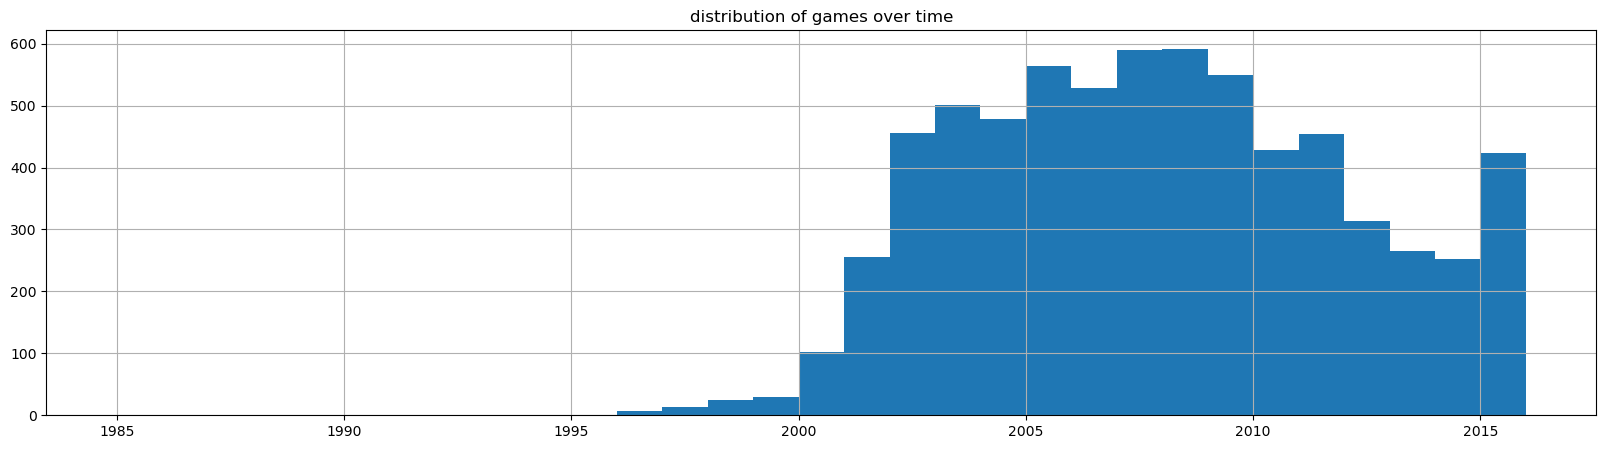

In [22]:
games_clean.year.hist(figsize=(20,5), bins=31)
plt.title('distribution of games over time')
plt.show();

number of games insignificant until years 2000, then peak and decline between 2010-15

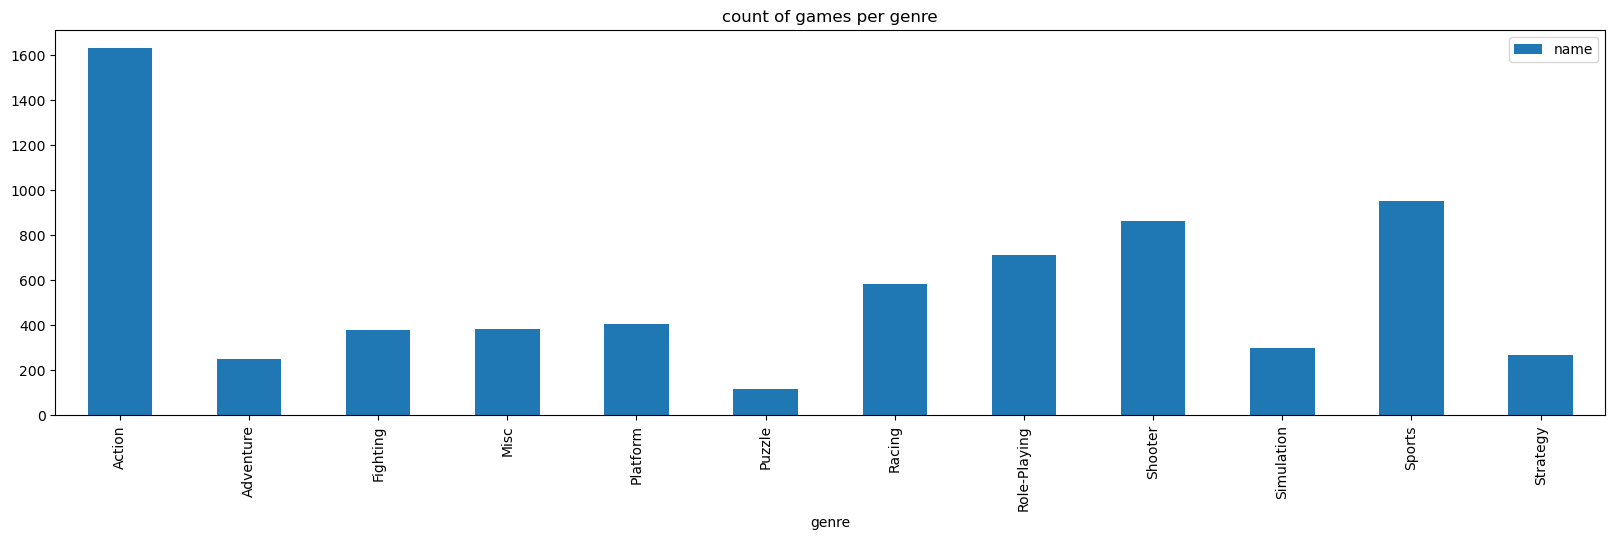

In [23]:
games_clean.pivot_table(index='genre',values='name',aggfunc='count').plot(title='count of games per genre',kind='bar',figsize=(20,5))
plt.show();

action by far the most popular genre, followed by shooters and sports

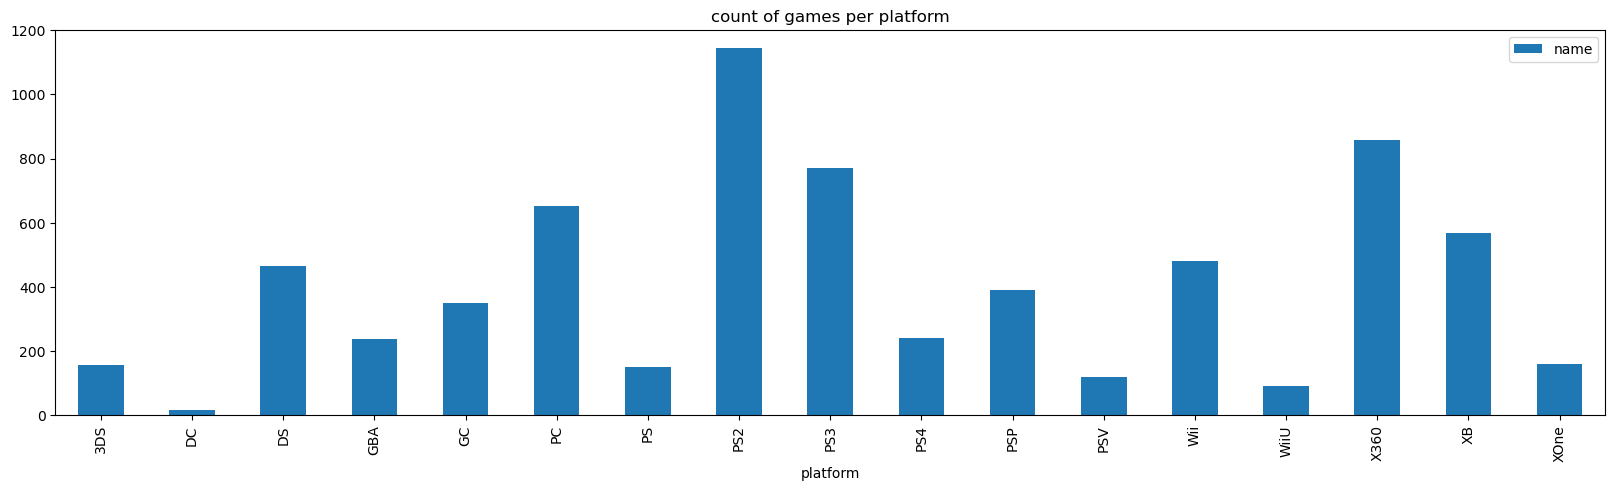

In [24]:
games_clean.pivot_table(index='platform',values='name',aggfunc='count').plot(title='count of games per platform',kind='bar',figsize=(20,5))
plt.show();

big differences between the popularity of different platforms

In [25]:
games_clean.rating.value_counts()

T       2378
E       2090
M       1433
E10+     930
RP         1
AO         1
K-A        1
Name: rating, dtype: int64

K-A, AO, RP will be dropped as outliers in ratings

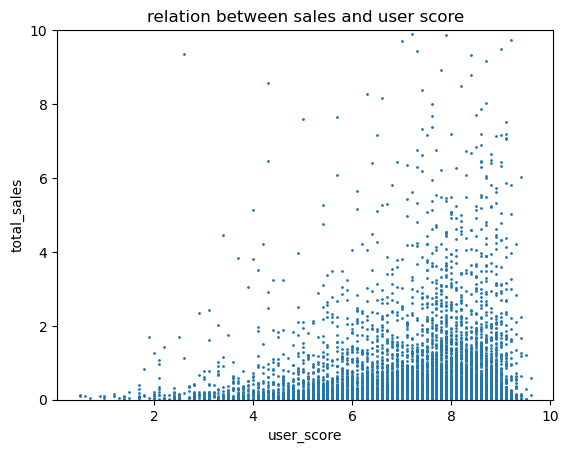

In [26]:
games_clean.plot.scatter(x='user_score', y='total_sales', ylim=(0,10),s=1)
plt.title('relation between sales and user score')
plt.show();

weak positive correlation between user score and total sales

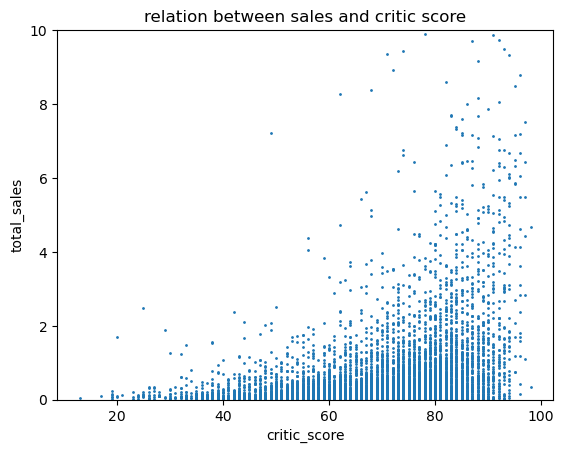

In [27]:
games_clean.plot.scatter(x='critic_score', y='total_sales', ylim=(0,10), s=1)
plt.title('relation between sales and critic score')
plt.show();

medium positive correlation between critic score and total sales

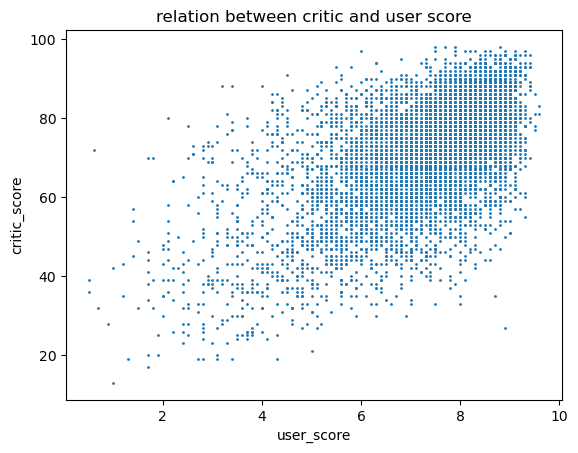

In [28]:
games_clean.plot.scatter(x='user_score', y='critic_score',s=1)
plt.title('relation between critic and user score')
plt.show();

strong correlation between critic and user score

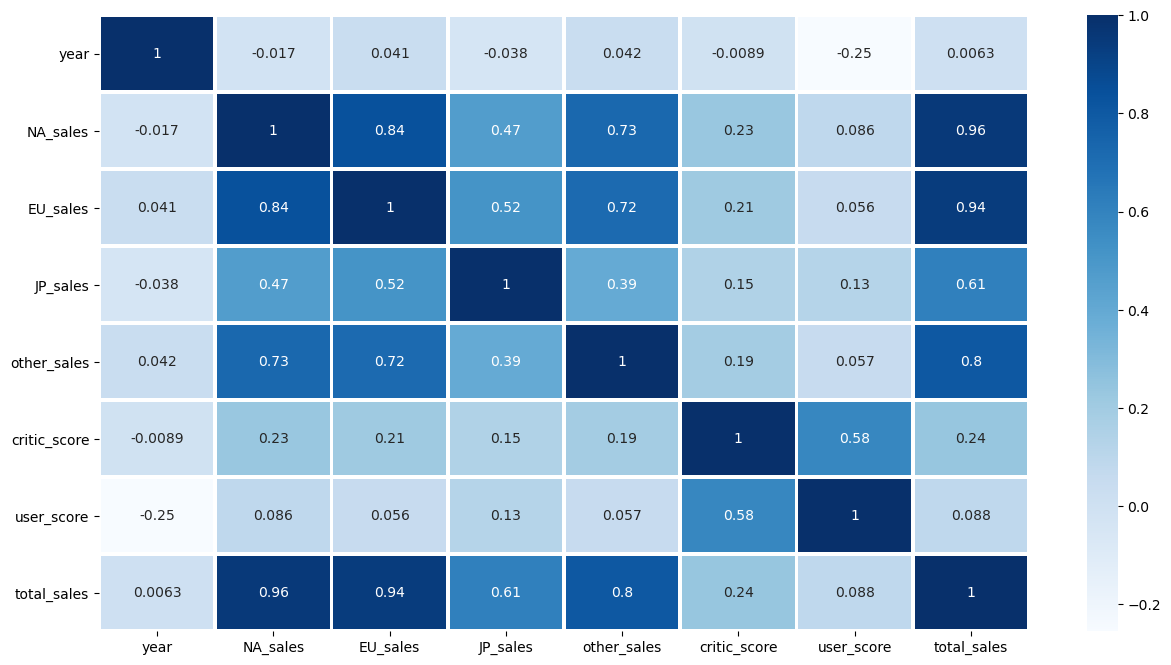

In [29]:
gcc = games_clean.corr()

plt.figure(figsize=(15,8))
sns.heatmap(gcc, annot=True,cmap='Blues',linewidth=2)
plt.show();

We use the strong relation (R=0.58) between user and critic score to substitute missing values by one, where the other is given. Critic score has a medium positive correlation with total_sales (R=0.23) so we retrieve missing critic scores via regression. The user scores have a medium negative correlation with the release year (R=-0.25), so we'll substitute missing user scores with the mean user score of other games from the respective year. Finally ratings are closely linked to the genre of the game (e.g. shooters are for a mature audience only) so we'll randomly assign rating values where missing according to the probablity distribution of the respective genre.

#### 1.3 replace missing values in critic score, user score and rating columns

1.3.1 substitute missing critic (1-100) for user scores (1-10) and vice versa

In [30]:
games[games.critic_score.isnull()& (games.user_score.isnull() | (games.user_score=='tbd'))].count()[0]

7896

In [31]:
def user_or_critic(r):
    user_score = r['user_score']
    critic_score = r['critic_score']
    
    if user_score is np.nan and critic_score is not np.nan:
        return critic_score / 10
    elif user_score=='tbd' and critic_score is not np.nan:
        return critic_score / 10
    elif critic_score is np.nan and (user_score is not np.nan and user_score!='tbd'):
        return user_score * 10
    else:
        return 'this is fine'

games['user_or_critic']=games.apply(user_or_critic, axis=1)

user score 'tbd' values are treated as NaN and substituted by critic score in ratio 1:10, where possible.

In [32]:
games[games.critic_score.isnull() & games.user_or_critic.notnull() & (games.user_or_critic!='this is fine')].count()[0]

0

In [33]:
games[games.user_or_critic.notnull() & (games.user_or_critic!='this is fine')].count()[0]

1091

0 critic scores can be substituted by user scores, 1091 missing or tbd user scores can be substituted by critic scores

In [34]:
games.user_score.fillna(games.user_or_critic, inplace=True)

In [35]:
games.user_score = np.where(games.user_score=='tbd',games.user_or_critic,games.user_score)

1.3.2. where both are missing, substitute missing user scores by mean of the same year (groupby) or total mean (older 20y)

In [36]:
# Round user score to one decimal
games.user_score = games.user_score.apply(lambda x: round(float(x),1))

In [37]:
# calculate mean of user score per year
games['user_year'] = games.groupby('year')['user_score'].transform(lambda x: round(x.mean(),1))

In [38]:
games.user_score.fillna(games.user_year, inplace=True)

In [39]:
games[games.user_score.isnull()].groupby('year')['name'].count()

year
1980      9
1981     46
1982     36
1983     17
1984     14
1986     21
1987     16
1989     17
1990     16
1991     41
1993     60
1995    219
Name: name, dtype: int64

There are still missing values, because in years 1980-1995 all user scores were missing - presumably because they were not a thing at this point in time. We'll substitute for now with the overall mean, but drop data from those years later anyway.

In [40]:
games['user_score'].fillna((games['user_score'].mean()), inplace=True)

In [41]:
games['user_score'] = pd.to_numeric(games['user_score'],errors = 'coerce')

user score data type fixed to float

In [42]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16459 entries, 0 to 16458
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            16459 non-null  object 
 1   platform        16459 non-null  object 
 2   year            16459 non-null  int32  
 3   genre           16459 non-null  object 
 4   NA_sales        16459 non-null  float64
 5   EU_sales        16459 non-null  float64
 6   JP_sales        16459 non-null  float64
 7   other_sales     16459 non-null  float64
 8   critic_score    7994 non-null   float64
 9   user_score      16459 non-null  float64
 10  rating          9778 non-null   object 
 11  total_sales     16459 non-null  float64
 12  user_or_critic  8563 non-null   object 
 13  user_year       15947 non-null  float64
dtypes: float64(8), int32(1), object(5)
memory usage: 1.7+ MB


1.3.3. where both are missing, substitute missing critic scores by regression of total_sales

In [43]:
games['critic_score'].corr(games['total_sales'])

0.24585327731241904

In [44]:
# generate regression equation with total sales as dependent and (missing) critic score as independent variable
games[games.critic_score.notnull()]

x = np.array(games[games.critic_score.notnull()]['total_sales']).reshape((-1,1))
y = np.array(games[games.critic_score.notnull()]['critic_score'])

regr = LinearRegression().fit(x,y)

print(regr.coef_)
print(regr.intercept_)

[1.86939124]
67.70412402091496


In [45]:
# create a new column with the calculated intercept and regression coefficient
games['critic_sales'] = round(regr.intercept_ + games['total_sales']*regr.coef_,1)

In [46]:
games['critic_sales'] = np.where(games.critic_sales>100,100,games.critic_sales)

In [47]:
games.critic_score.fillna(games.critic_sales, inplace=True)

In [48]:
Covariance = np.cov(games.critic_score, games.critic_sales, bias=True)[0][1]
print(Covariance)

7.504254608533883


1.3.4. substitute missing rating by random.choice from genre distribution

In [49]:
games[(games.rating=='AO')|(games.rating=='K-A')|(games.rating=='RP')|(games.rating=='EC')].count()[0]

13

In [50]:
games = games.drop(games[(games.rating=='AO')|(games.rating=='K-A')|(games.rating=='RP')|(games.rating=='EC')].index)
games.reset_index(drop=True,inplace=True)

drop outliers in rating, that is rows with very rare values

In [51]:
rating_pivot = games.pivot_table(index='genre', columns='rating',values='total_sales',aggfunc='count', margins=True)

In [52]:
rating_pivot['ratio_E'] = round(rating_pivot['E']/rating_pivot.All,4)
rating_pivot['ratio_E10+'] = round(rating_pivot['E10+']/rating_pivot.All,4)
rating_pivot['ratio_M'] = round(rating_pivot['M']/rating_pivot.All,4)
rating_pivot['ratio_T'] = round(rating_pivot['T']/rating_pivot.All,4)

In [53]:
rating_pivot

rating,E,E10+,M,T,All,ratio_E,ratio_E10+,ratio_M,ratio_T
genre,,,,,,,,,
Action,410.0,468.0,596.0,670.0,2144,0.1912,0.2183,0.2780,0.3125
Adventure,159.0,67.0,98.0,114.0,438,0.3630,0.1530,0.2237,0.2603
Fighting,8.0,19.0,48.0,357.0,432,0.0185,0.0440,0.1111,0.8264
Misc,449.0,166.0,13.0,228.0,856,0.5245,0.1939,0.0152,0.2664
Platform,354.0,141.0,3.0,63.0,561,0.6310,0.2513,0.0053,0.1123
Puzzle,284.0,42.0,NaN,10.0,336,0.8452,0.1250,NaN,0.0298
Racing,577.0,95.0,18.0,167.0,857,0.6733,0.1109,0.0210,0.1949
Role-Playing,83.0,111.0,161.0,415.0,770,0.1078,0.1442,0.2091,0.5390
Shooter,47.0,56.0,553.0,340.0,996,0.0472,0.0562,0.5552,0.3414


Use the calculated ratio in the genre/rating pivot as probability distribution per genre to randomly substitute missing values in the rating column

In [54]:
esrb = ['E','E10+','M','T']

def random_esrb(genre):
    if genre=='Action':
        return np.random.choice(esrb, p=[0.19,0.22,0.28,0.31])
    elif genre=='Adventure':
        return np.random.choice(esrb, p=[0.36,0.15,0.23,0.26])
    elif genre=='Fighting':
        return np.random.choice(esrb, p=[0.02,0.04,0.11,0.83])
    elif genre=='Misc':
        return np.random.choice(esrb, p=[0.52,0.19,0.02,0.27])
    elif genre=='Platform':
        return np.random.choice(esrb, p=[0.63,0.25,0.01,0.11])
    elif genre=='Puzzle':
        return np.random.choice(esrb, p=[0.84,0.13,0.00,0.03])
    elif genre=='Racing':
        return np.random.choice(esrb, p=[0.67,0.11,0.02,0.20])
    elif genre=='Role-Playing':
        return np.random.choice(esrb, p=[0.11,0.14,0.21,0.54])
    elif genre=='Shooter':
        return np.random.choice(esrb, p=[0.05,0.06,0.55,0.34])
    elif genre=='Simulation':
        return np.random.choice(esrb, p=[0.58,0.08,0.01,0.33])
    elif genre=='Sports':
        return np.random.choice(esrb, p=[0.79,0.07,0.01,0.13])
    elif genre=='Strategy':
        return np.random.choice(esrb, p=[0.20,0.23,0.08,0.49])
    else:
        return 'unknown'

games['esrb']=games['genre'].apply(random_esrb)

In [55]:
games.rating.fillna(games.esrb,inplace=True)

In [56]:
games.isnull().sum()

name                 0
platform             0
year                 0
genre                0
NA_sales             0
EU_sales             0
JP_sales             0
other_sales          0
critic_score         0
user_score           0
rating               0
total_sales          0
user_or_critic    7889
user_year          512
critic_sales         0
esrb                 0
dtype: int64

no missing values left beside the additional columns we created and will drop subsequently

In [57]:
games.drop(['user_or_critic','user_year','critic_sales','esrb'], axis=1, inplace=True)

In [58]:
games.head(3)

,name,platform,year,genre,NA_sales,EU_sales,JP_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,100.0,5.8,E,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52


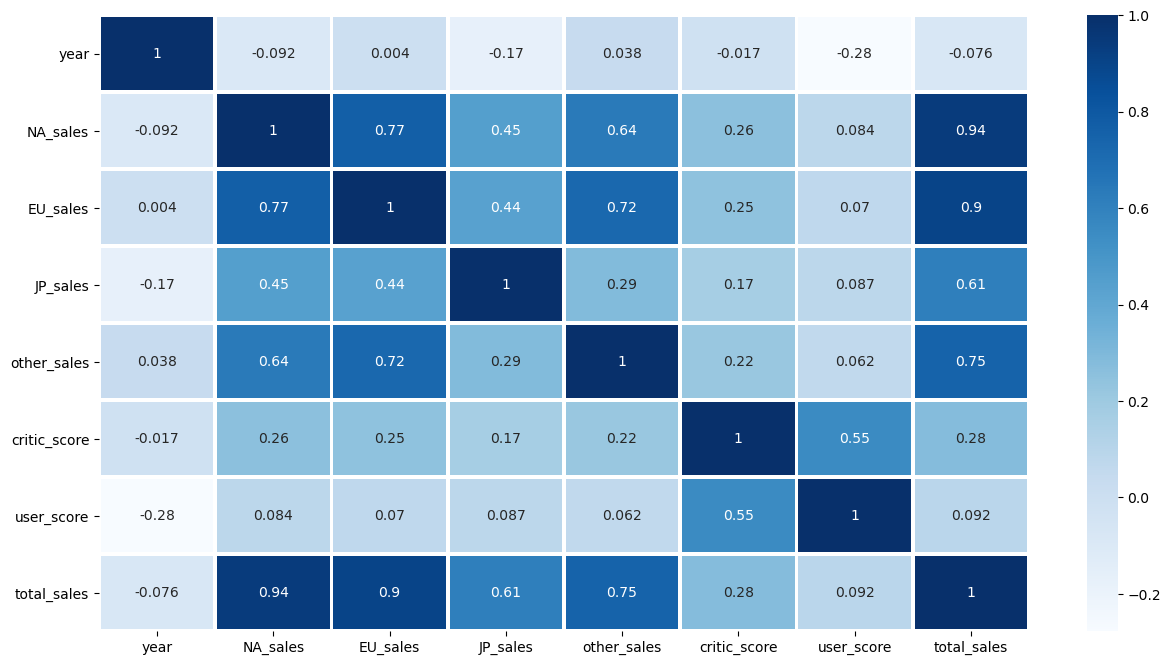

In [59]:
gc = games.corr()

plt.figure(figsize=(15,8))
sns.heatmap(gc, annot=True,cmap='Blues',linewidth=2)
plt.show();

**Intermediary conclusion 1**: The games data set contained no duplicates but a significant percentage of missing values in several columns. Added up in the games_clean data frame that was used to explore dependencies in the data, less than half of the rows were without NaN (or tbd) values. Using the correlation between parameters as a marker, various means like regression analysis, grouping data by another column and randomizing categorical values were used to substitute the NaN values and keep data loss at a minimum (only around 300 rows needed to be dropped).

### 2. Analyzing the data for years, platforms and genres

In [60]:
print('count of games from 2002 on:',games[games.year>2001].count()[0])
print('count of games until 2001 on:', games[games.year<=2001].count()[0])
print('')
print('percentage last 15 years:',round(games[games.year>2001].count()[0]/games.count()[0],2))
print('percentag older 15 years:',round(games[games.year<=2001].count()[0]/games.count()[0],2))

count of games from 2002 on: 13643
count of games until 2001 on: 2803

percentage last 15 years: 0.83
percentag older 15 years: 0.17


Remove outliers from total sales column and focus on relevant time period starting from 2002 on.

In [61]:
games.shape

(16446, 12)

In [62]:
games = games[games.year>2001]

In [63]:
# drop outliers with a z-score of more than 3 standard deviations above the mean value in total sales
games=games[(np.abs(stats.zscore(games['total_sales'])) < 3)]

In [64]:
games.shape

(13493, 12)

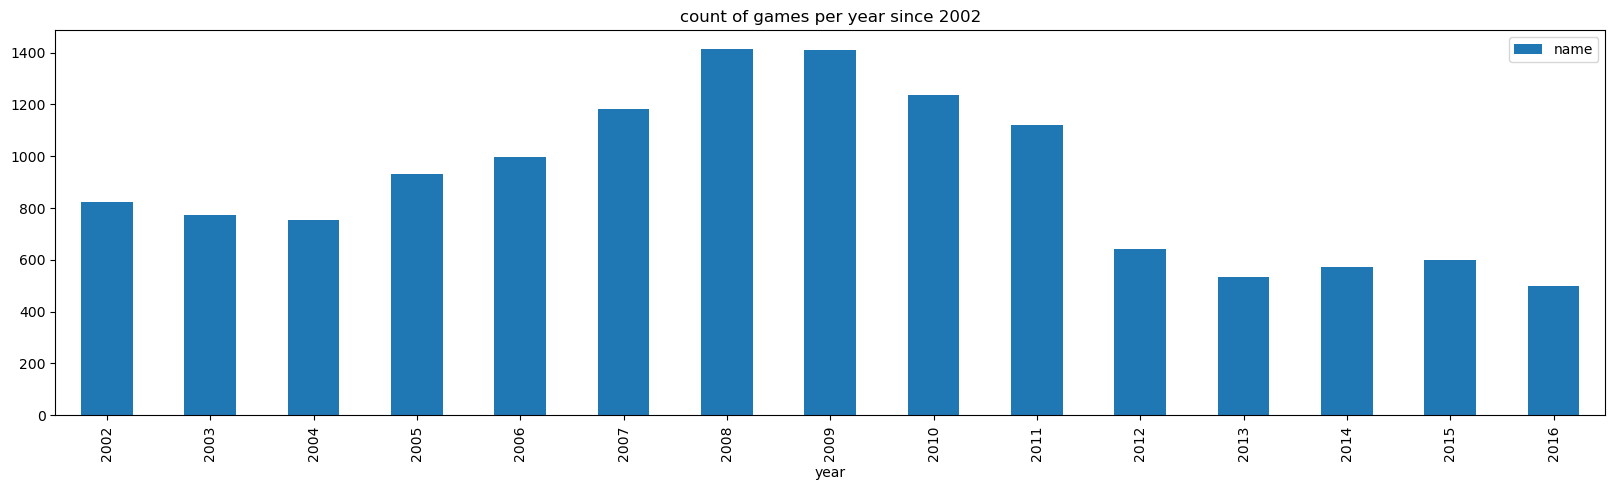

In [65]:
games.pivot_table(index='year',values='name',aggfunc='count').plot(title='count of games per year since 2002',kind='bar',figsize=(20,5))
plt.show();

The number of games published peaked between 2007-2011

In [66]:
Playstation = games[games.platform.isin(['PS','PS2','PS3','PS4','PSP','PSV']) & (games.year>2006)]
not_Playstation = games[~games.platform.isin(['PS','PS2','PS3','PS4','PSP','PSV']) & (games.year>2006)]

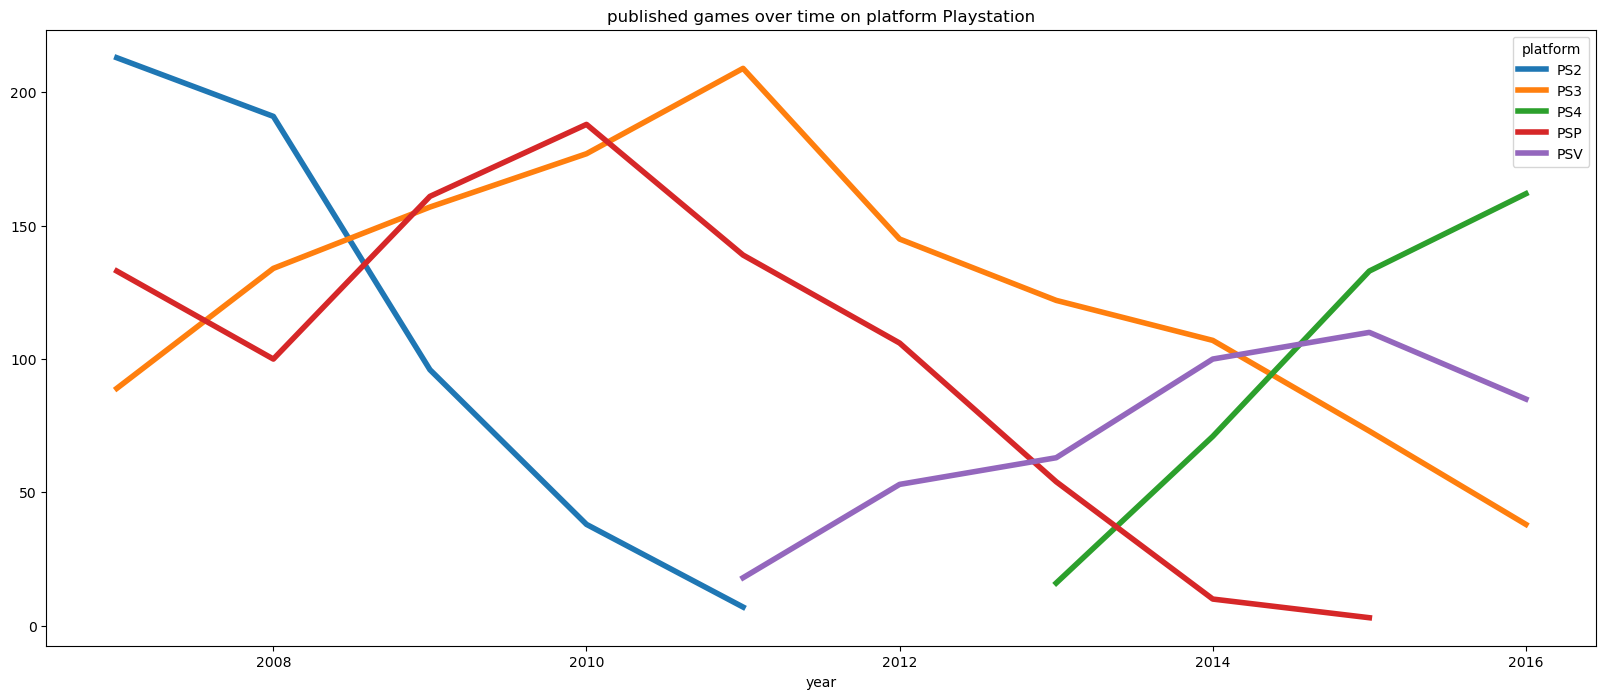

In [67]:
Playstation.pivot_table(index='year',columns='platform',values='name',aggfunc='count').plot(title='published games over time on platform Playstation', figsize=(20,8), linewidth=4);
plt.show();

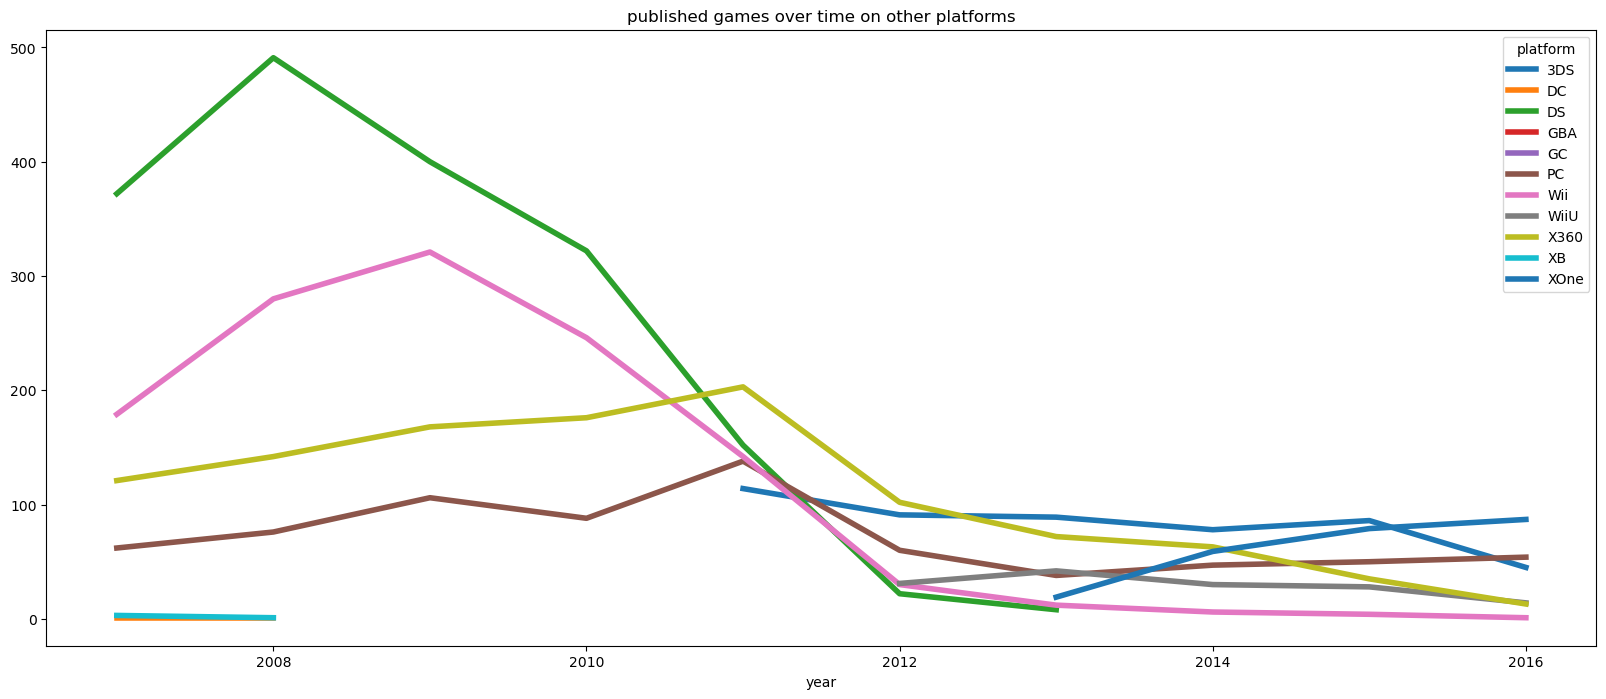

In [68]:
not_Playstation.pivot_table(index='year',columns='platform',values='name',aggfunc='count').plot(title='published games over time on other platforms',figsize=(20,8),linewidth=4)
plt.show();

Platforms follow a clear product cycle. Successful ones are relevant for around eight years. Peaks around 2010 come from DS and Wii, in earlier years from GameBoy. PS4 and XOne are on the rise.

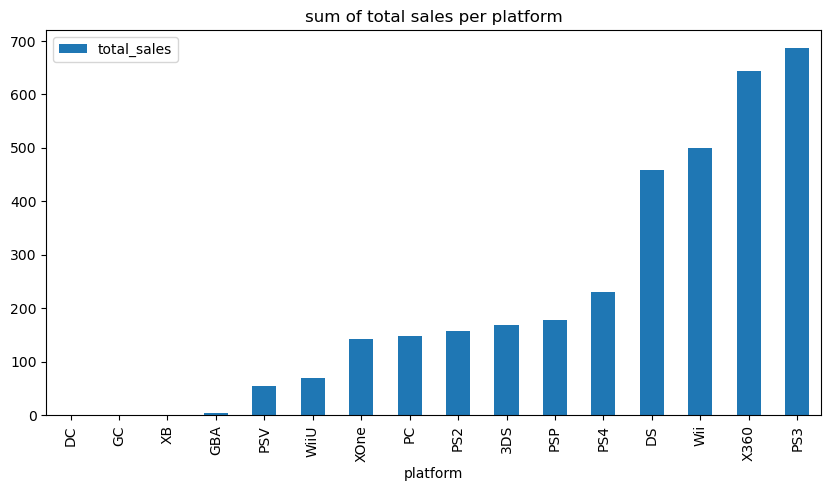

In [69]:
games[games['year']>2006].pivot_table(index='platform',values='total_sales',aggfunc='sum').sort_values('total_sales').plot(title='sum of total sales per platform',kind='bar', figsize=(10,5))
plt.show();

Top five platforms in total sales over the last 10 years are PS3, X360, Wii, DS, PS4

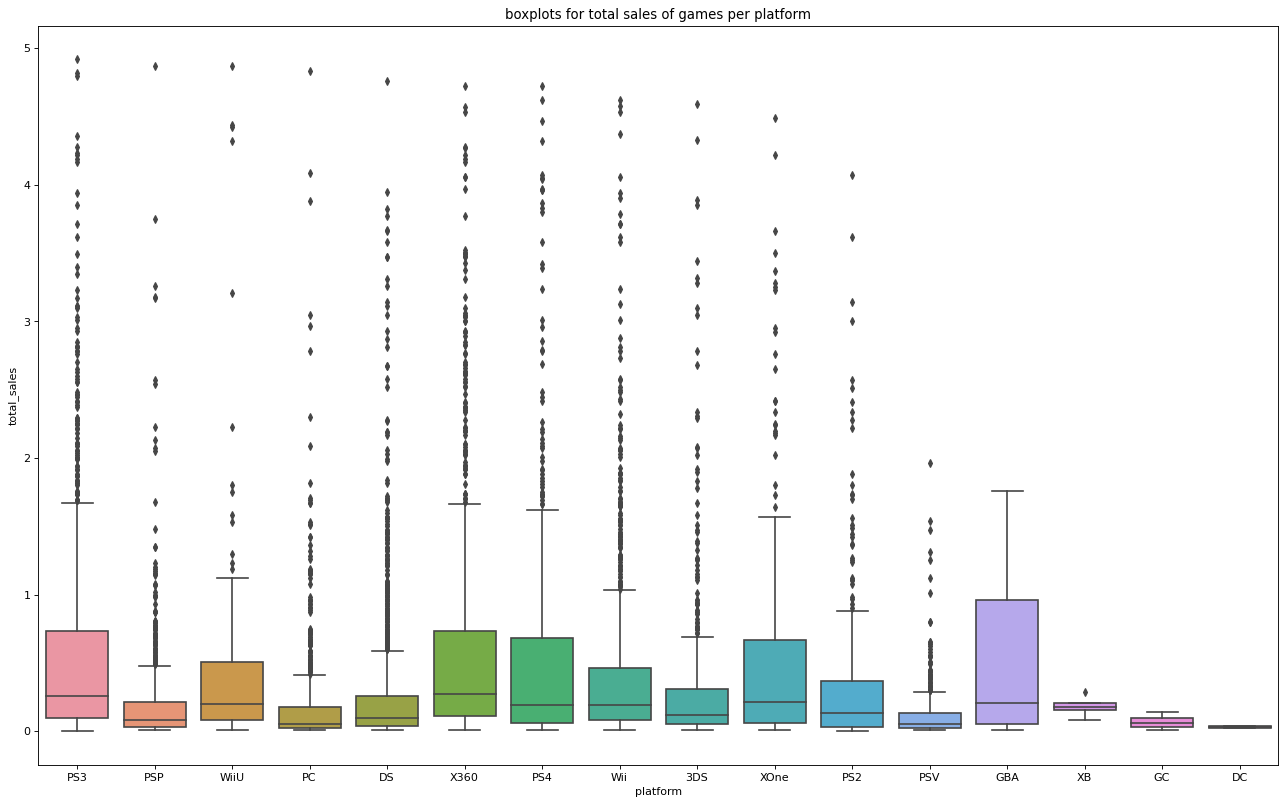

In [70]:
plt.figure(figsize=(20,12), dpi= 80)
sns.boxplot(x='platform', y='total_sales', data=games[games['year']>2006], notch=False)
plt.title('boxplots for total sales of games per platform')
plt.show();

Most platforms are having a long tail in total sales with outliers representing games with especially high sales. Thus the median is closer to the lower end of the boxplot than to Q3. The differences in sales are significant (as derived already from the bar chart). Platforms that are currently growing (like PS4) may denote a higher average that platforms that are already shrinking (like PS2).

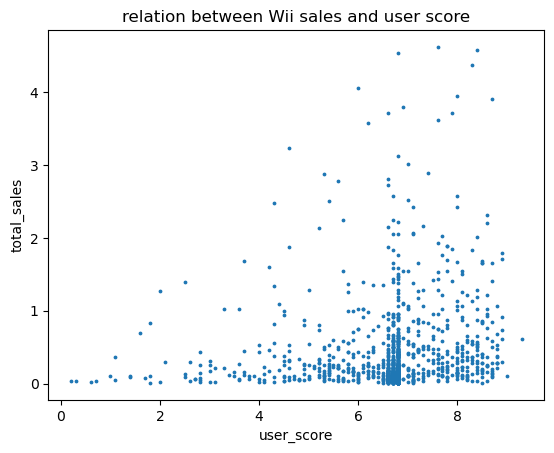

In [71]:
# Picking out one platform to analyze relationship between user / critic score and sales
games[games.platform=='Wii'].plot.scatter(x='user_score', y='total_sales',s=3)
plt.title('relation between Wii sales and user score')
plt.show();

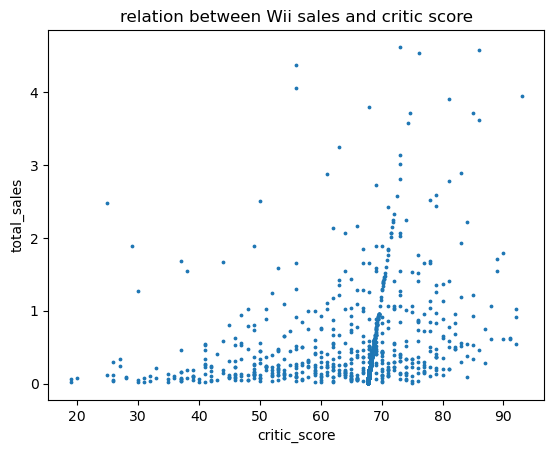

In [72]:
games[games.platform=='Wii'].plot.scatter(x='critic_score', y='total_sales',s=3)
plt.title('relation between Wii sales and critic score')
plt.show();

In [73]:
print(games[games.platform=='Wii'].user_score.corr(games[games.platform=='Wii'].total_sales))
print(games[games.platform=='Wii'].critic_score.corr(games[games.platform=='Wii'].total_sales))

0.1310005964170369
0.18259090384462937


User and critic score are weakly positively correlated with sales for platform Wii. Interestingly the correlation is weaker than on the overall, noticible especially for the critic score, where the regression graph of values substituted ealier is clearly recognizable.

In [74]:
wii_games = (games[games.platform=='Wii']['name']).tolist()

In [75]:
# query for games that exist also on Wii platform, but where platform is not Wii
games.query('name in @wii_games and platform !="Wii"').count()[0]

1555

In [76]:
games.query('name in @wii_games').groupby('platform')[['total_sales']].sum().sort_values('total_sales',ascending=False).head(5)

,total_sales
platform,
Wii,517.19
X360,175.86
PS3,148.11
DS,125.45
PS2,108.33


Wii leads sales of the same games among the platforms by far (in contrast to the overall), presumably because of the significance of exclusive titels for other platforms like PlayStation

In [77]:
games.pivot_table(index='genre', values='total_sales', aggfunc=['count','sum','mean','median'])

,count,sum,mean,median
,total_sales,total_sales,total_sales,total_sales
genre,,,,
Action,2938,1189.70,0.404935,0.17
Adventure,1154,165.74,0.143622,0.05
Fighting,592,256.15,0.432686,0.18
Misc,1531,524.33,0.342476,0.14
Platform,641,302.03,0.471186,0.21
Puzzle,450,105.96,0.235467,0.08
Racing,914,359.18,0.392976,0.15
Role-Playing,1205,476.63,0.395544,0.15


Most profitable genres in total are action, sports and misc. On average per game shooter, platform and sports are the most profitable genres. Low sales come from strategy, puzzle and simulation games.

**Intermediary conclusion 2:** Platform and genre are important factors for the success of a game. Platforms follow a life cycle though, so games will only be successful in the years where the platform is on the rise. Among the genres action games and shooters are very popular. Interstingly user and critic scores are only of minor importance for the total sales of a game. 

### 3. User profile per region NA, EU, JP

In [78]:
games.groupby('platform')[['NA_sales','EU_sales','JP_sales','other_sales','total_sales']].sum().sort_values('total_sales',ascending=False).head(10)

,NA_sales,EU_sales,JP_sales,other_sales,total_sales
platform,,,,,
PS2,433.22,253.24,98.97,143.13,928.56
PS3,304.96,235.46,68.27,98.00,706.69
X360,430.18,195.42,10.04,61.47,697.11
DS,295.93,110.95,112.94,38.60,558.42
Wii,306.71,134.86,32.18,43.44,517.19
PSP,102.21,60.27,71.35,37.51,271.34
PS4,83.50,97.91,14.08,35.30,230.79
XB,157.58,52.74,0.96,7.69,218.97
GBA,131.93,49.27,27.68,4.44,213.32


In [79]:
for i in ['NA_sales','EU_sales','JP_sales']:
    print(games.groupby('platform')[[i]].sum().sort_values(i,ascending=False).head(5))
    print('')

          NA_sales
platform          
PS2         433.22
X360        430.18
Wii         306.71
PS3         304.96
DS          295.93

          EU_sales
platform          
PS2         253.24
PS3         235.46
X360        195.42
Wii         134.86
DS          110.95

          JP_sales
platform          
DS          112.94
PS2          98.97
3DS          74.89
PSP          71.35
PS3          68.27



PS2 has been the most successful platform overall in the last years, with X360 being second in NA and DS even taking the top spot in Japan.

In [80]:
for i in ['NA_sales','EU_sales','JP_sales']:
    print(games.groupby('genre')[[i]].sum().sort_values(i,ascending=False).head(5))
    print('')

              NA_sales
genre                 
Action          596.27
Sports          448.71
Shooter         307.88
Misc            267.71
Role-Playing    192.22

         EU_sales
genre            
Action     354.75
Sports     223.40
Shooter    187.12
Misc       137.20
Racing     127.38

              JP_sales
genre                 
Role-Playing    156.38
Action          110.11
Misc             66.38
Sports           50.92
Adventure        35.09



Tastes in genres are close to identical in NA and EU with the top three being action, sports and shooters. In Japan however role-playing is the most popular.

In [81]:
games.groupby('rating')[['total_sales']].count().sort_values('total_sales',ascending=False)

,total_sales
rating,
E,5240
T,4083
E10+,2090
M,2080


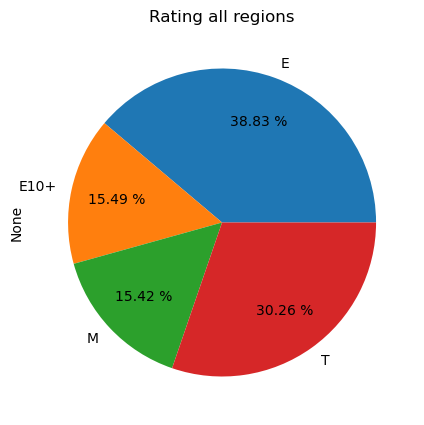

In [82]:
rating_region = games.groupby('rating').size()

rating_region.plot(kind='pie', subplots=True, autopct='%.2f %%', pctdistance=0.7, figsize=(5, 5))
plt.title('Rating all regions')
plt.show();

Over all regions ESRB 'everyone' rating is the most frequent.

In [83]:
games.groupby('rating')[['NA_sales','EU_sales','JP_sales']].sum()

,NA_sales,EU_sales,JP_sales
rating,,,
E,1019.44,520.73,181.63
E10+,370.51,203.53,82.27
M,490.05,334.21,87.72
T,708.28,385.29,210.18


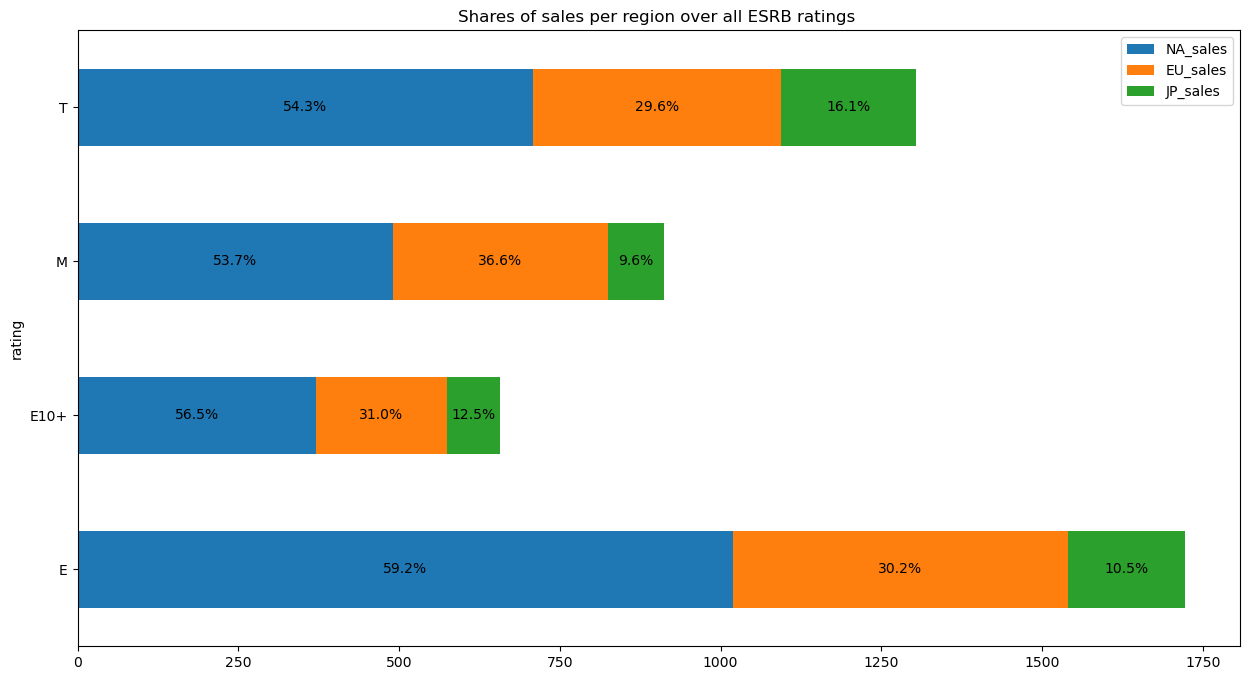

In [84]:
rr = games.groupby('rating')[['NA_sales','EU_sales','JP_sales']].sum()
rr = rr.reset_index()

rr.plot(x='rating', kind='barh',stacked=True, figsize=(15,8), mark_right = True);
plt.title('Shares of sales per region over all ESRB ratings ')

rr_total = rr['NA_sales'] + rr['EU_sales'] + rr['JP_sales']
rr_rel = rr[rr.columns[1:]].div(rr_total, 0)*100
  
for n in rr_rel:
    for i, (cs, ab, pc) in enumerate(zip(rr.iloc[:, 1:].cumsum(1)[n], rr[n], rr_rel[n])):
        plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%', va = 'center', ha = 'center')
        
plt.show()

ESRB ratings are affecting sales in the different regions to some degree: Europe seems to have a taste for 'Mature' games, while the share of 'Teen' games is overproportional in Japan. NA is quite balanced, with games for 'Everyone' having a slightly higher share in in the other regions.

**Intermediary Conclusion 3:** The three major sales regions show some differences in taste concerning platforms, genres and ratings that should be taken into account if a game is to be marketed in one region specifically.

### 4. Testing hypothesis concering user score

H0: mean of user score for games on platform XOne is **equal** to mean on platform PC <br>
H1:  mean of user score for games on platform XOne is **unequal** to mean on platform PC

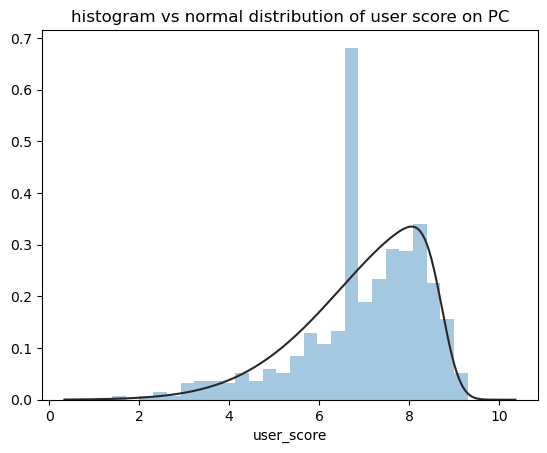

In [85]:
sns.distplot(games[games.platform=='PC']['user_score'], fit=skewnorm, kde=False)
plt.title('histogram vs normal distribution of user score on PC')
plt.show();

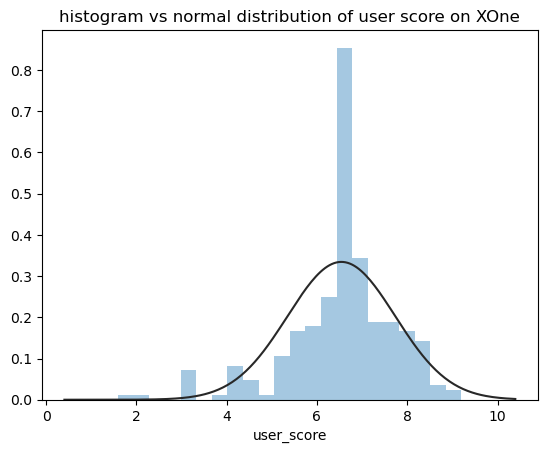

In [86]:
sns.distplot(games[games.platform=='XOne']['user_score'], fit=norm, kde=False)
plt.title('histogram vs normal distribution of user score on XOne')
plt.show();

The user scores for platform PC and XOne follow roughly a (skewed) normal distribution - this observation is however less affirmative due to our handling of missing values above. An overproportional percentage of the values is close to the mean.

In [87]:
games[(games.platform=='XOne')|(games.platform=='PC')].pivot_table(index='platform', values='user_score', aggfunc=['count','mean','median','var','std'])

,count,mean,median,var,std
,user_score,user_score,user_score,user_score,user_score
platform,,,,,
PC,889,6.966254,7.1,1.894513,1.376413
XOne,244,6.541393,6.6,1.428609,1.195244


The mean difference of user score between PC and XOne is half a point, potentially statistically significant. As the differences between sample size and variance are quite big, the Welch test will be used.

In [88]:
XOne_score = games[games.platform=='XOne']['user_score']
PC_score = games[games.platform=='PC']['user_score']

alpha = 0.05

# welch test as we are comparing two means of different samples with unqequal count + variances
welch_platform = stats.ttest_ind(XOne_score,PC_score, equal_var = False)

print(welch_platform)

if welch_platform.pvalue < alpha:
    print('We reject H0 that the user score for games on XOne and PC have equal means at 95% confidence')
else:
    print('We cannot reject H0 that the user score for games on XOne and PC have equal means at 95% confidence')

Ttest_indResult(statistic=-4.754245278565039, pvalue=2.709989692923636e-06)
We reject H0 that the user score for games on XOne and PC have equal means at 95% confidence


H0: mean of user score for games from Action genre is **equal** to mean from Sports genre <br>
H1:  mean of user score for games from Action genre is **unequal** to mean from Sports genre

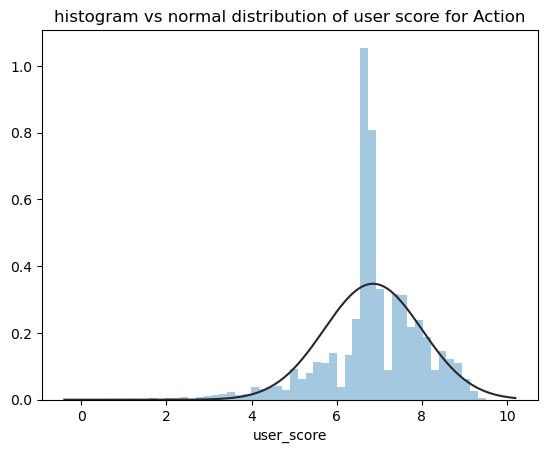

In [89]:
sns.distplot(games[games.genre=='Action']['user_score'], fit=norm, kde=False)
plt.title('histogram vs normal distribution of user score for Action')
plt.show();

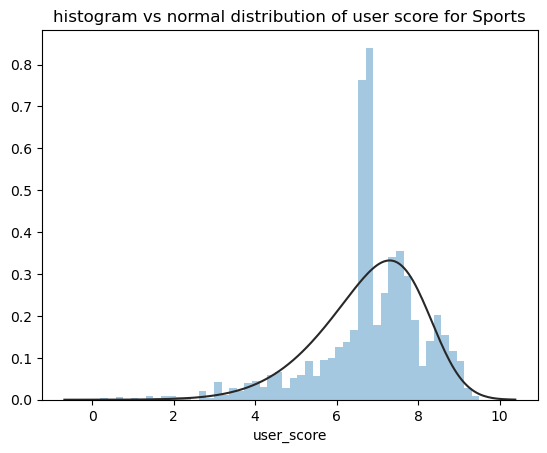

In [90]:
sns.distplot(games[games.genre=='Sports']['user_score'], fit=skewnorm, kde=False)
plt.title('histogram vs normal distribution of user score for Sports')
plt.show();

The user scores for genres Action and Sports follow roughly a (skewed) normal distribution - this observation is however less affirmative due to our handling of missing values above. An overproportional percentage of the values is close to the mean.

In [91]:
games[(games.genre=='Action') | (games.genre=='Sports')].pivot_table(index='genre', values='user_score', aggfunc=['count','mean','median','var','std'])

,count,mean,median,var,std
,user_score,user_score,user_score,user_score,user_score
genre,,,,,
Action,2938,6.853642,6.8,1.319335,1.148623
Sports,1798,6.836374,6.8,1.735538,1.317398


The mean difference of user score between action and sports genre is only marginal, so chances that the confidence intervalls are not overlapping is small, even though the sample sizes are large. As variances are unequal, Welch test is used again.

In [92]:
Action_score = games[games.genre=='Action']['user_score']
Sports_score = games[games.genre=='Sports']['user_score']

alpha = 0.05

# welch test as we are comparing two means of different samples with unqequal count + variances
welch_genre = stats.ttest_ind(Action_score,Sports_score, equal_var = False)

print(welch_genre)

if welch_genre.pvalue < alpha:
    print('We reject H0 that the user score for games from genres Action and Sports have equal means at 95% confidence')
else:
    print('We cannot reject H0 that the user score for games from genres Action and Sports have equal means at 95% confidence')

Ttest_indResult(statistic=0.45916948189762036, pvalue=0.6461417589476417)
We cannot reject H0 that the user score for games from genres Action and Sports have equal means at 95% confidence


**Intermediary conclusion 4:** PC games receive higher average user scores than XOne games at alpha threshold 5%, while the differences of user scores between action and sports games are to small to be significant. Looking more closely at the p-value of the two tests, this result would have been the same for the other popular alpha levels 0.1 or 0.01

### 5. Conclusion

The goal of analysis was to identify parameters relevant for the sales success of a game in 2017. Important factors are: Is the platform on the rise (like PS4, XOne) and popular in the respective region (Japan: DS)? Is the genre of the game a shooter, action, platform or sports (in Japan: role-playing)? Does it receive high critic scores? Less important factors are the user score and the ESBR rating, with Japan showing a slight preference for 'Teen' and Europe for 'Mature' games. As the Welch test showed, user rating for some platforms varies significantly. Lastly it's worth noting that game sales follow time cycles, peaking between the years 2007-2011 and showing growth again since 2015.